### 1. Download data from **Kaggle** 

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
url_path='https://www.kaggle.com/datasets/alincijov/self-driving-cars'
od.download(url_path)

Skipping, found downloaded files in "./self-driving-cars" (use force=True to force download)


In [ ]:
from os.path import join
import pandas as pd
import numpy as np
from PIL import Image

def process_dataframes(train_df,test_df,size_capacity=0.1):
  '''

  train_df: DataFrame wich contains the id of the image and bbox coordinates
  for training.

  test_df: DataFrame wich contains the id of the image and bbox coordinates for
  validation

  size_capacity: float wich represents the size of the data from train_df and test_df
  
  '''
  columns=['frame','ymin','xmin','ymax','xmax','class_id']
  train_df_=train_df[columns]
  test_df_=test_df[columns]
  train_size=int(len(train_df_)*size_capacity)
  test_size=int(len(test_df_)*size_capacity)
  print(f'Size of train data: {train_size}')
  print(f'Size of test data: {test_size}')
  return train_df_.iloc[:train_size,:],test_df_.iloc[:test_size,:]

train_data=pd.read_csv('/content/self-driving-cars/labels_train.csv')
test_data=pd.read_csv('/content/self-driving-cars/labels_val.csv')

train_df,test_df=process_dataframes(train_data,test_data,0.007)

Size of train data: 926
Size of test data: 228


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   frame     926 non-null    object
 1   ymin      926 non-null    int64 
 2   xmin      926 non-null    int64 
 3   ymax      926 non-null    int64 
 4   xmax      926 non-null    int64 
 5   class_id  926 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 43.5+ KB


In [ ]:
import os
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
  image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  image=load_img(image_path)
  image=img_to_array(image)
  train_images_np.append(image)

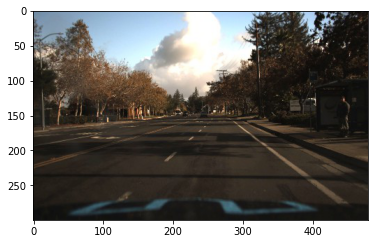

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
%matplotlib inline

img=load_img('/content/self-driving-cars/images/1478019952686311006.jpg')
img=img_to_array(img)
img/=255.0
plt.imshow(img)

In [ ]:
num_classes=len(train_df['class_id'].unique())
train_df['class_id'].unique()

array([1, 3, 2, 5, 4])

In [ ]:
num_classes=len(train_df['class_id'].unique())

def preprocess_bboxes(bboxes,image):
  shape=image.shape
  y_factor=shape[0]
  x_factor=shape[1]
  shape_img=np.array([y_factor,x_factor,y_factor,x_factor])
  bboxes/=shape_img
  return bboxes


def create_tensor_from_dataframe(data,images_path,batch_size):

  '''
  Returns a tf.data.Dataset wich contains (image,true_shapes,bbox,class)

  We need to preprocess the coordinates of bboxes and image.

  data: DataFrame wich contains the id,bboxes and labels.
  images_path: Path of the directory that contains the images.
  batch_size: The batch size for the data.

  '''

  images,true_shapes,bboxes,classes=[],[],[],[]
  for img in data.to_numpy():
    name_img=img[0]
    coordinates_img=img[1:-1]
    label_img=tf.one_hot(img[-1]-1,num_classes)

    img_PIL=load_img(join(images_path,name_img))
    img_np=img_to_array(img_PIL)
    '''Solo usa resize si todas las formas son diferentes, ya que no funcionara np.stack
       Tampoco se normaliza
    '''
    #img_np=tf.image.resize(img_np,(640,640)).numpy()
    #img_np/=255.0
    coordinates_img=preprocess_bboxes(coordinates_img,img_np)
    images.append(img_np)
    true_shapes.append(np.array(img_np.shape))
    bboxes.append(coordinates_img)
    classes.append(tf.convert_to_tensor(label_img))


  img_tensor=np.stack(images)
  true_shapes=np.stack(true_shapes)
  bboxes=np.stack(bboxes).astype('float32')
  classes=np.stack(classes).astype('float32')
  data=tf.data.Dataset.from_tensor_slices((img_tensor,true_shapes,bboxes,classes))
  data=data.batch(batch_size)
  data=data.shuffle(100)
  data_=[[img,shapes,bboxes,classes] for (img,shapes,bboxes,classes) in data]
  print(f'Tensor created!')
  return data_


images_path='/content/self-driving-cars/images'
BATCH_SIZE=5
train_ds=create_tensor_from_dataframe(train_df,images_path,BATCH_SIZE)
test_ds=create_tensor_from_dataframe(test_df,images_path,BATCH_SIZE)

Tensor created!
Tensor created!


### 2. Make the model

Podemos encontrar muchos Checkpoints de los modelos pre entrenandos en la API de tensorflow Object Detection.

tensorflow object detection API: https://github.com/tensorflow/models/tree/master/research/object_detection

checkpoints: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

Notas:


*   No importa las dimensiones de las imágenes, ya que con model.preprocess() se adecua a las dimensiones del modelo.
*   La prediccion será un diccionario que contiene diversos resultados que serán procesados por model.postprocess()





In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

#### 2.1. Using Object Detection API

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Process is interrupted.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#Descargar el checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
#Descomprime la carpeta
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
#Mueve el checkpoint
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-08-10 19:33:28--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.68.128, 2404:6800:4003:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.68.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   277MB/s    in 0.8s    

2022-08-10 19:33:29 (277 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [ ]:
config_path='/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path='/content/models/research/object_detection/test_data/checkpoint/ckpt-0'

'''Obtenemos la configuración del modelo para cambiarla'''

configs=config_util.get_configs_from_pipeline_file(config_path)
model_config=configs['model']
model_config.ssd.num_classes=num_classes
model_config.ssd.freeze_batchnorm=True
model=model_builder.build(model_config=model_config,is_training=True)

### 2.2 Checkpoint

Actualizamos los valores pre entrenados y los colocamos en el nuetro.

In [ ]:
box_predictor_tmp = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=model._box_predictor._box_prediction_head,
    )

model_tmp = tf.compat.v2.train.Checkpoint(
          _feature_extractor=model._feature_extractor,
          _box_predictor=box_predictor_tmp)
ckpt = tf.compat.v2.train.Checkpoint(model=model_tmp)
ckpt.restore(checkpoint_path).expect_partial()

In [ ]:
images,shapes=model.preprocess(tf.ones((1,640,640,3)))
prediction_dict=model.predict(images,shapes)
_=model.postprocess(prediction_dict,shapes)

In [ ]:
'''Miremos las variables'''

for i in model.variables:
  print(i.name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_2/kernel:0
WeightSharedConvolutional

#### 2.3 Training

Solo necesitamos entrenar algunas variables del modelo, ya que utilizaremos pesos pre entrenados.

In [ ]:
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

trainable_variables = model.trainable_variables
to_fine_tune = []

for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

In [ ]:
def get_train_step_func(model,vars_to_tune,optimizer):
  @tf.function
  def train_step_func(images,true_bboxes,true_labels):
    model.provide_groundtruth(
        groundtruth_boxes_list=true_bboxes,
        groundtruth_classes_list=true_labels
    )
    with tf.GradientTape() as tape:
      images,shapes=model.preprocess(images)
      prediction_dict = model.predict(images, shapes)
      losses_dict=model.loss(prediction_dict,shapes)
      total_loss=losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      
      grads=tape.gradient(total_loss,vars_to_tune)
      optimizer.apply_gradients(zip(grads,vars_to_tune))

    return total_loss  
  return train_step_func  

def get_val_func(model):
  @tf.function
  def validation_func(images,true_bboxes,true_labels):

    model.provide_groundtruth(
        groundtruth_boxes_list=true_bboxes,
        groundtruth_classes_list=true_labels
    )
    images,shapes=model.preprocess(images)
    prediction_dict = model.predict(images,shapes)
    losses_dict=model.loss(prediction_dict,shapes)
    total_loss=losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

    return total_loss
  return validation_func  

In [ ]:
def train_on_ds(train_func,train_ds):
  size_ds=len(train_ds)
  total_loss=0
  for k in range(size_ds):
    img,shapes,bboxes,labels=train_ds[k]
    labels=labels[:,np.newaxis]
    bboxes=[bboxes[i][np.newaxis,:] for i in range(bboxes.shape[0])]
    labels=[labels[i] for i in range(labels.shape[0])]
    #print(bboxes)
    #print(labels)
    #print(img)
    loss=train_func(img,bboxes,labels)
    total_loss+=loss.numpy()

  return total_loss/size_ds

def val_on_ds(val_func,val_ds):
  size_ds=len(val_ds)
  total_loss=0
  for k in range(size_ds):
    img,shapes,bboxes,labels=val_ds[k]
    labels=labels[:,np.newaxis]
    bboxes=[bboxes[i][np.newaxis,:] for i in range(bboxes.shape[0])]
    labels=[labels[i] for i in range(labels.shape[0])]
    loss=val_func(img,bboxes,labels)
    total_loss+=loss.numpy()

  return total_loss/size_ds  

In [ ]:
epochs=100
optimizer=tf.keras.optimizers.SGD(0.001,momentum=0.9)
train_func=get_train_step_func(model,to_fine_tune,optimizer)
val_func=get_val_func(model)

history={'train_loss':[],'test_loss':[]}
with tf.device('/GPU:0'):
  for epoch in range(1,epochs+1):
    train_loss=train_on_ds(train_func,train_ds)
    test_loss=val_on_ds(val_func,test_ds)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f'epoch:{epoch} train_loss:{train_loss} test_loss:{test_loss}')

epoch:1 train_loss:32.24824839253579 test_loss:25.383406804955523
epoch:2 train_loss:26.79663607638369 test_loss:21.067432859669562
epoch:3 train_loss:22.731467648219038 test_loss:20.366051238516103
epoch:4 train_loss:20.628816401445736 test_loss:16.69978730574898
epoch:5 train_loss:17.40990618351967 test_loss:14.378752998683764
epoch:6 train_loss:16.0781513837076 test_loss:14.624593817669412
epoch:7 train_loss:14.090056776359518 test_loss:13.258670081263004
epoch:8 train_loss:12.700742403666178 test_loss:11.844239846519802
epoch:9 train_loss:11.622859351096615 test_loss:11.707314242487369
epoch:10 train_loss:10.848977268383067 test_loss:10.056466869685961
epoch:11 train_loss:9.559083912962226 test_loss:9.48949702926304
epoch:12 train_loss:8.50098821937397 test_loss:8.3236206666283
epoch:13 train_loss:7.580881129028977 test_loss:8.088963731475499
epoch:14 train_loss:7.000204342026865 test_loss:6.927606385687123
epoch:15 train_loss:6.0425157457269645 test_loss:6.406337302664052
epoch:16

KeyboardInterrupt: ignored

In [ ]:
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.3)
  image_np_with_annotations/=255.0 
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [74]:
lista=['carro', 'camion', 'peaton', 'ciclista', 'luz']
dict_={}
for i in range(num_classes):
  dict_[i]={'id':i,'name':lista[i]}

In [75]:
dict_

{0: {'id': 0, 'name': 'carro'},
 1: {'id': 1, 'name': 'camion'},
 2: {'id': 2, 'name': 'peaton'},
 3: {'id': 3, 'name': 'ciclista'},
 4: {'id': 4, 'name': 'luz'}}

In [76]:
def create_validation_images(data,images_path):
  images=[]
  for img in data.to_numpy():
    name_img=img[0]
    img_PIL=load_img(join(images_path,name_img))
    img_np=img_to_array(img_PIL)
    images.append(img_np)
  return images

In [80]:
train_df,test_df=process_dataframes(train_data,test_data,0.05)

Size of train data: 6620
Size of test data: 1634


In [81]:
validation_images=create_validation_images(test_df,images_path)

In [83]:
ckpt_model=tf.train.Checkpoint(model=model)
ckpt_model.save('ckpt')

'ckpt-1'

In [85]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [86]:
!cp /content/ckpt-1.data-00000-of-00001 "drive/My Drive/"

In [87]:
!cp /content/ckpt-1.index "drive/My Drive/"

In [91]:
for i,img in enumerate(validation_images):
  img_=tf.expand_dims(img,axis=0)
  img_,shape=model.preprocess(img_)
  detections=model.predict(img_,shape)
  detections=model.postprocess(detections,shape)
  plot_detections(
      img,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32),
      detections['detection_scores'][0].numpy(),
      dict_,figsize=(15,20),image_name="CAR_framev2_"+('%04d' % i)+".jpg"
  )

In [ ]:
filenames = glob.glob('CAR_framev2_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

In [99]:
import cv2

height,width,depth=image.shape
size=(width,height)

out = cv2.VideoWriter('video_OD_CARS.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 50, size)
 
for i in range(len(images)):
    out.write(images[i])
out.release()

In [100]:
!cp /content/video_OD_CARS.mp4 "drive/My Drive/"